In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
#import keras
import matplotlib.pyplot as plt

from subprocess import check_output
print(check_output(["ls", "../Data"]).decode("utf8"))


data_dictionary.txt
macro.csv
macro.xlsx
sample_submission.csv
test.csv
train.csv
train.xlsx



In [2]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable

In [3]:
import math
import datetime
from sklearn.preprocessing import LabelEncoder

In [4]:
# Загружаем данные. Индексом ставим timestamp.

In [456]:
macro = pd.read_csv('../Data/macro.csv',index_col=['timestamp'], parse_dates=['timestamp'], dayfirst=True)
train = pd.read_csv('../Data/train.csv',index_col=['timestamp'], parse_dates=['timestamp'], dayfirst=True)
test = pd.read_csv('../Data/test.csv',index_col=['timestamp'], parse_dates=['timestamp'], dayfirst=True)

In [736]:
llist = range(0,185)
##llist = range(-60,90)
#xxrain = (pd.concat([1/(macro.usdrub.shift(i)*macro.eurrub.shift(i)) for i in llist], axis=1,keys=['L%s' % i for i in llist])).dropna()
xL1 = (pd.concat([100/(macro.usdrub.shift(i))    for i in llist], axis=1,keys=['L1%s' % i for i in llist])).dropna()
xL2 = (pd.concat([(macro.usdrub.shift(i))**2 for i in llist], axis=1,keys=['L2%s' % i for i in llist])).dropna()
xL3 = (pd.concat([(macro.usdrub.shift(i))**3 for i in llist], axis=1,keys=['L3%s' % i for i in llist])).dropna()
xLL =  pd.concat([xL1,xL2,xL3], axis=1) 
xLL = xL1
##xLL = (pd.concat([(macro.usdrub.shift(i)) for i in llist], axis=1,keys=['L%s' % i for i in llist])).dropna()
xLL.dropna()
del llist
##xLL.head(),xLL.tail()
xLL.shape, xLL.index.min(),xLL.index.max()

((2297, 185),
 Timestamp('2010-07-07 00:00:00', freq='D'),
 Timestamp('2016-10-19 00:00:00', freq='D'))

In [737]:
macro.shape, train.shape, test.shape, xLL.shape

((2484, 99), (30471, 291), (7662, 290), (2297, 185))

In [738]:
# Массивы для перекодировки значений в числовую форму
#ntrain, ntest = pd.concat([train,macro],axis=1,join='inner'), pd.concat([test,macro],axis=1,join='inner')

ntrain, ntest, nmacro = train.copy(), test.copy(), macro.copy()

print('macro=',macro.index.min(),macro.index.max())
print('train=',train.index.min(),train.index.max())
print('test =',test.index.min(),test.index.max())
print('xLL =',xLL.index.min(),xLL.index.max())
print 'macro=', macro.shape, 'ntrain=', ntrain.shape, 'ntest=', ntest.shape, 'xLL=', xLL.shape

('macro=', Timestamp('2010-01-01 00:00:00'), Timestamp('2016-10-19 00:00:00'))
('train=', Timestamp('2011-08-20 00:00:00'), Timestamp('2015-06-30 00:00:00'))
('test =', Timestamp('2015-07-01 00:00:00'), Timestamp('2016-05-30 00:00:00'))
('xLL =', Timestamp('2010-07-07 00:00:00', freq='D'), Timestamp('2016-10-19 00:00:00', freq='D'))
macro= (2484, 99) ntrain= (30471, 291) ntest= (7662, 290) xLL= (2297, 185)


In [739]:
# Очистка данных (пока в процессе продумывания)

In [740]:
def clear_datas (data) :
    
    # clear life_sq
    data['life_sq'].dropna(0);
    
    while (data.life_sq.loc[(data.life_sq>90) & (data.life_sq>data.full_sq)].count()>0) :
        data.life_sq.loc[(data.life_sq>90) & (data.life_sq>data.full_sq)] /= 10.0;

    iid = data[data.life_sq>data.full_sq].index
    data.ix[iid,'life_sq'] = data.ix[iid,'full_sq'];
    
    data.loc[(data.kitch_sq>1000)|(data.kitch_sq>data.life_sq)] = np.NAN
    
    return

In [741]:
# Убираем индекс, переходим на нумерацию для простоты
ntrain = ntrain.reset_index()
ntest  = ntest.reset_index()
nmacro = nmacro.reset_index()
xLL    = xLL.reset_index()
dict_col_le = {}

In [742]:
# Сериализация символьных значений

In [743]:
dict_col_le = {}
for cc in ntrain.select_dtypes(exclude=['int64', 'float64','datetime64']).columns :
    
    # Добиваем пустоты в колонке
    ntrain[cc] = ntrain[cc].fillna('NANA')
    ntest[cc]  = ntest[cc].fillna('NANA')
    
    le = LabelEncoder()
    # Заполняем класс значениями
    le.fit(list(ntrain[cc].values.astype('str')) + list(ntest[cc].values.astype('str')))
    # Перегоняем и сохраняем в словаре для будущего
    ntrain[cc] = le.transform(list(ntrain[cc].values.astype('str')))
    ntest[cc]  = le.transform(list(ntest[cc].values.astype('str')))
    
    #print(cc,le.classes_)
    dict_col_le[cc] = le
    
for cc in nmacro.select_dtypes(exclude=['int64', 'float64','datetime64']).columns :
    
    # Добиваем пустоты в колонке
    nmacro[cc] = nmacro[cc].fillna('NANA')
    
    le = LabelEncoder()
    # Заполняем класс значениями
    le.fit(list(nmacro[cc].values.astype('str')))
    # Перегоняем и сохраняем в словаре для будущего
    nmacro[cc] = le.transform(list(nmacro[cc].values.astype('str')))
    
    #print(cc,le.classes_)
    dict_col_le[cc] = le
    
# Добиваем пустоты
ntrain = ntrain.fillna(0)
ntest  = ntest.fillna(0)
nmacro = nmacro.fillna(0)

In [744]:
dict_col_le.keys()
#ntrain.child_on_acc_pre_school.unique()
#ntest.child_on_acc_pre_school.unique()
#dict_col_le['sub_area'].inverse_transform(ntrain.sub_area.unique())

['railroad_terminal_raion',
 'oil_chemistry_raion',
 'culture_objects_top_25',
 'product_type',
 'sub_area',
 'modern_education_share',
 'incineration_raion',
 'detention_facility_raion',
 'thermal_power_plant_raion',
 'radiation_raion',
 'old_education_build_share',
 'railroad_1line',
 'ecology',
 'big_market_raion',
 'water_1line',
 'nuclear_reactor_raion',
 'big_road1_1line',
 'child_on_acc_pre_school']

In [745]:
# Дополнение train полями usd, eur и расчет дополнительных результативных полей в train (стоимость м2 в usd и eur для жилой и общей площади)

In [746]:
def add_datetime (data) :
    data['day']     = data.timestamp.dt.day  
    data['month']   = data.timestamp.dt.month
    data['year']    = data.timestamp.dt.year
    data['week']    = data.timestamp.dt.week
    data['weekday'] = data.timestamp.dt.weekday
    
    month_year = (data.timestamp.dt.month + data.timestamp.dt.year * 100)
    month_year_cnt_map = month_year.value_counts().to_dict()
    data['year_month_cnt'] = month_year.map(month_year_cnt_map)
    data['year_month']     = (data.timestamp.dt.month + data.timestamp.dt.year * 100)
    
    week_year = (data.timestamp.dt.week + data.timestamp.dt.year * 100)
    week_year_cnt_map = week_year.value_counts().to_dict()
    data['year_week_cnt'] = week_year.map(week_year_cnt_map)
    data['year_week']     = (data.timestamp.dt.week + data.timestamp.dt.year * 100)
    
    return

def add_features_1 (data) :
    
    #data = data.reset_index()
    
    data['build_year0']   = data.build_year;
    data.ix[data.build_year<=1500,'build_year0']=data.ix[data.build_year<=1500,'year']-2;
    
    data['full0']         = data.full_sq; data.ix[data.full_sq<=1,'full0']=50.0
    data['life0']         = data.life_sq; data.ix[data.life_sq<=1,'life0']=data.ix[data.life_sq<=1,'full0']; 
    data.ix[data.life_sq>data.full_sq,'life0'] = data.ix[data.life_sq>data.full_sq,'full0']
    
    data['floor0']        = data.floor;     data.ix[data.floor<1,'floor0']=1.0;
    data['max_floor0']    = data.max_floor; 
    data.ix[data.max_floor0<data.floor0,'max_floor0']=data.ix[data.max_floor0<data.floor0,'floor0'];
    
    data.ix[data.kitch_sq>data.life0,'kitch_sq'] = data.ix[data.kitch_sq>data.life0,'life0']
    
    data.num_room.loc[data.num_room<1] = 1
    
    data['floor:max']     = data.floor0/data.max_floor0  
    data['max-floor']     = data.max_floor0-data.floor0
    data['kitch:full']    = data.kitch_sq/data.full0
    data['life:full']     = data.life0/data.full0
    data['full:room']     = data.full0/data.num_room
    data['life:room']     = data.life0/data.num_room
    data['full-life']     = data.full0-data.life0
    data['build-year']    = data.build_year0-data.year
    
    #data = data.set_index('timestamp')
    
    return(data)


In [747]:
ttrain, ttest = ntrain.copy(), ntest.copy();

add_datetime(ttrain)
add_datetime(ttest)

add_features_1(ttrain)
add_features_1(ttest)

if False :
    ttrain['usd']=ttrain.price_doc/ttrain.usdrub; 
    ttrain['eur']=ttrain.price_doc/ttrain.eurrub

    ttrain['usdm2full'] = ttrain.usd/(ttrain.full0)
    ttrain['usdm2life'] = ttrain.usd/(ttrain.life0)

    usdm2Max = 7000
    usdm2Min = 1000

    ttrain = ttrain[ttrain.usdm2full<=usdm2Max]
    ttrain = ttrain[ttrain.usdm2full>=usdm2Min]

    ttrain['eurm2full'] = ttrain.eur/(ttrain.full0)
    ttrain['eurm2life'] = ttrain.eur/(ttrain.life0)

    #ttrain['full_life'], ttest['full_life'] = (ttrain.full_sq+1)/(ttrain.life_sq+1), (ttest.full_sq+1)/(ttest.life_sq+1)

    ttrain['div_eurrub'],  ttest['div_eurrub']  = 1/ttrain.eurrub, 1/ttest.eurrub
    ttrain['div_usdrub'],  ttest['div_usdrub']  = 1/ttrain.usdrub, 1/ttest.usdrub
    ttrain['div_eurrub2'], ttest['div_eurrub2'] = ttrain.div_eurrub**2, ttest.div_eurrub**2
    ttrain['div_usdrub2'], ttest['div_usdrub2'] = ttrain.div_usdrub**2, ttest.div_usdrub**2

    ###ttrain['r']    = np.log1p(ttrain.price_doc) # 2017-05-31 LB = 0.86
    ###ttrain['r']    = np.log1p(ttrain.usdm2full) # 2017-06-02 LB = 0.51
    ###ttrain['r']    = ttrain.usdm2full # 2017-06-02 LB = 0.361
    ###ttrain['r'] = ttrain.price_doc/(ttrain.full_sq+1.0) # # 2017-06-02 LB = 0.41066
    ##ttrain['r'] = ttrain.usdm2life # # 2017-06-02 LB = 0.37543
#######################################################################################################

coef = 1.0 # 0.969
ttrain['r'] = ttrain.price_doc # ttrain.usdm2full*coef 

#llist = range(5,15)+range(25,35)+range(55,65)+range(85,95)+range(115,125)+range(145,155)+range(175,185)
##llist = range(1,185)
##xxrain = (pd.concat([100*100/(macro.usdrub.shift(i)*macro.eurrub.shift(i)) for i in llist], axis=1,keys=['L%s' % i for i in llist])).dropna()

##ttrain = ttrain.set_index('timestamp')
##ttest  = ttest.set_index('timestamp')

##ttrain = pd.concat([ttrain,xxrain],axis=1,join='inner')
##ttest  = pd.concat([ttest,xxrain], axis=1,join='inner')

##ttrain = ttrain.reset_index()
##ttest  = ttest.reset_index()

print(train.shape,ttrain.shape,test.shape,ttest.shape) #,llist)
ttrain.head()

((30471, 291), (30471, 315), (7662, 290), (7662, 313))


,timestamp,id,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,max_floor0,floor:max,max-floor,kitch:full,life:full,full:room,life:room,full-life,build-year,r
0,2011-08-20,1,43,27.0,4.0,0.0,0.0,0.0,1.0,0.0,...,4.0,1.0,0.0,0.0,0.627907,43.0,27.0,16.0,-2.0,5850000
1,2011-08-23,2,34,19.0,3.0,0.0,0.0,0.0,1.0,0.0,...,3.0,1.0,0.0,0.0,0.558824,34.0,19.0,15.0,-2.0,6000000
2,2011-08-27,3,43,29.0,2.0,0.0,0.0,0.0,1.0,0.0,...,2.0,1.0,0.0,0.0,0.674419,43.0,29.0,14.0,-2.0,5700000
3,2011-09-01,4,89,50.0,9.0,0.0,0.0,0.0,1.0,0.0,...,9.0,1.0,0.0,0.0,0.561798,89.0,50.0,39.0,-2.0,13100000
4,2011-09-05,5,77,77.0,4.0,0.0,0.0,0.0,1.0,0.0,...,4.0,1.0,0.0,0.0,1.000000,77.0,77.0,0.0,-2.0,16331452


In [748]:
if False :
    ttrain = ttrain.reset_index()
    ttest  = ttest.reset_index()

In [749]:
if False :
    ttrain = ttrain.set_index('timestamp')
    ttest  = ttest.set_index('timestamp')
    plt.plot(ttrain[ttrain.index>'2014'].usdm2full.resample('1d').median()/macro.eurrub/macro.eurrub);
    #plt.plot(4000*35*40/(macro.eurrub[macro.index>'2014']*macro.usdrub[macro.index>'2014']))
    plt.show()
    ttrain = ttrain.reset_index()
    ttest  = ttest.reset_index()

In [750]:
# Начинаем строить модель по остаткам train данных

In [751]:
# 2017-06-07 Поля на выброс после оценки
if False :
    len(listOut1),len(resXsort), resXsort, listOut1
    listOut1=ttrain.columns.values.tolist()
    len(listOut1)
    listOut1=listOut1[200:300]

In [858]:
col_res     = ['r'];
col_notuse  = ['usdm2full','usdm2life','eurm2full','eurm2life','price_doc','id','eur','usd','timestamp']+col_res
##col_notuse += ['full_sq', 'life_sq', 'floor', 'max_floor', 'build_year']

### begin 2017-06-04 after

col_notuse += ['build_year0','max_floor0', 'full0'] #, 'life0']  #, 'floor0']
#######col_notuse += ['usdrub','eurrub'] 
col_notuse += ['life_sq','floor','full0']

col_notuse += ['material'] #'build-year'] # ???????????????????
##col_notuse += ['day','year','week','brent'] # ???????????????????   22-06
##col_notuse += ['area_m','sub_area','state'] # ???????????????????  22-06
##col_notuse += ['state'] # ??????????????????? 22-06

##################################################################
col_notuse += [ntrain.columns[i] for i in range(0,len(ntrain.columns)) if ntrain.dtypes[i]=='O']
col_notuse += [ntrain.columns[i] for i in range(0,len(ntrain.columns)) if len(ntrain[ntrain.columns[i]].unique())<=1]

col_use    = [ x for x in ttrain.columns.tolist() if x not in col_notuse];


In [859]:
#
#  Процедуры для синхронного построения из массивов (train, test, macro, ll) оценочных массивов (train_x, train_y, test_y)
#     в разных компоновочных вариантах
#

def ttConcat   (train,test,right) :
    train  = train.set_index('timestamp')
    test   = test.set_index('timestamp')
    right  = right.set_index('timestamp')
    
    ntrain, ntest = pd.concat([train,right],axis=1,join='inner'), pd.concat([test,right],axis=1,join='inner')
    
    train  = train.reset_index()
    test   = test.reset_index()
    right  = right.reset_index()
    
    ntrain = ntrain.reset_index()
    ntest  = ntest.reset_index()
    
    return ntrain, ntest

def pd1   (col_notuse,col_res,train,test) :
    col_use    = [ x for x in train.columns.tolist() if x not in col_notuse];
    return train[col_use],train[col_res],test[col_use]

def pd1m  (col_notuse,col_res,train,test,macro) :
    ntrain, ntest = ttConcat(train,test,macro)
    return pd1(col_notuse,col_res,ntrain,ntest)

def pd1l  (col_notuse,col_res,train,test,ll) :
    ntrain, ntest = ttConcat(train,test,ll)
    return pd1(col_notuse,col_res,ntrain,ntest)

def pd1ml (col_notuse,col_res,train,test,macro,ll) :
    print train.shape, test.shape
    ntrain, ntest = ttConcat(train,test,macro)
    print ntrain.shape, ntest.shape
    ntrain, ntest = ttConcat(ntrain,ntest,ll)
    print ntrain.shape, ntest.shape
    return pd1(col_notuse,col_res,ntrain,ntest)


In [860]:
#train_x, train_y, test_x  = pd1ml (col_notuse,col_res,ttrain,ttest,nmacro,xLL)
#train_x, train_y, test_x  = pd1m (col_notuse,col_res,ttrain,ttest,nmacro)
#train_x, train_y, test_x  = pd1l (col_notuse,col_res,ttrain,ttest,xLL)
train_x, train_y, test_x  = pd1 (col_notuse,col_res,ttrain,ttest)
#train_x, train_y, test_x  = pd1l (col_notuse,col_res,ttrain,ttest,xLL)

print train.shape, train_x.shape, train_y.shape, test.shape, test_x.shape

(30471, 291) (30471, 305) (30471, 1) (7662, 290) (7662, 305)


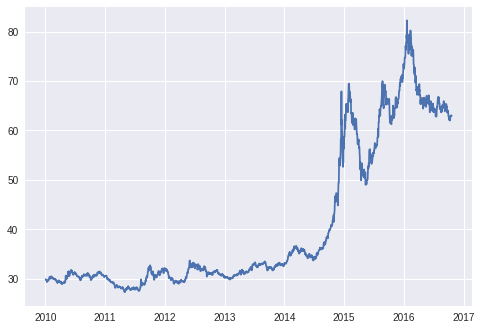

In [861]:
plt.plot(macro.usdrub); plt.show()

In [862]:
print len(train),len(train_x)

30471 30471


In [863]:
import xgboost as xgb

def rmsle(preds, dtrain):
    labels = dtrain.get_label()
    assert len(preds) == len(labels)
    preds_ = np.abs(preds)
    logs   = np.log1p(labels)-np.log1p(preds_)
    logs2  = np.sqrt((logs*logs).mean())
    return 'rmsle', logs2

def xgbtrain (param, train_x, train_y, num_round=1800, stopping=10, ratio=0.9) :
    
    split = int(round(ratio*len(train_y)))
    dtrain = xgb.DMatrix(train_x[:split],label=train_y[:split])
    dvalid = xgb.DMatrix(train_x[split:],label=train_y[split:])
    watchlist  = [(dtrain,'train'),(dvalid,'valid')]
    rvalid={}
    bst = xgb.train(param, dtrain, num_round, watchlist, evals_result=rvalid, early_stopping_rounds=stopping)
    return(bst,np.array(rvalid['valid']['rmse']))


In [864]:
# Строим основные массивы
dtrain = xgb.DMatrix(train_x,label=train_y)
dtest  = xgb.DMatrix(test_x)

In [865]:
if False :
    param = {'silent':0, 'objective':'reg:linear', 'eta':0.2, 'max_depth':19, 'subsample':0.7, 'colsample_bytree':0.99, 'metrics':'rmse'}
    ##param = {'silent':0, 'objective':'reg:linear', 'eta':0.02, 'max_depth':12, 'subsample':0.7, 'colsample_bytree':0.99, 'metrics':'rmse'}
    num_round = 1800 #300 # 300-the best , 1300 не дает эффекта

    print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M'))

    bst, rvalid_log = xgbtrain(param, train_x, train_y, num_round=num_round, stopping=30, ratio=0.9)

    train_g = bst.predict(dtrain,ntree_limit=rvalid_log.argmin())
    train_g = np.abs(train_g)
    _,train_rmsle = rmsle(train_g,dtrain)

    train_g = bst.predict(dtrain)
    train_g = np.abs(train_g)
    _,train_rmsle_full = rmsle(train_g,dtrain)

    print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M'), rvalid_log.argmin(), rvalid_log.min(), train_rmsle, train_rmsle_full)


In [866]:
#dtrainCV = xgb.DMatrix(train_x,label=train_y)
train_week_begin = 201401
##train_week_begin = 201340
dtrainCV = xgb.DMatrix(train_x[train_x.year_week>=train_week_begin],label=train_y[train_x.year_week>=train_week_begin])

In [867]:
param = {'silent':0, 'objective':'reg:linear', 'eta':0.2, 'max_depth':19, 'subsample':0.7, 'colsample_bytree':0.99, 'metrics':'rmse'}
##param = {'silent':0, 'objective':'reg:linear', 'eta':0.05, 'max_depth':19, 'subsample':0.7, 'colsample_bytree':0.99, 'metrics':'rmse'}
#param = {'silent':0, 'objective':'reg:linear', 'eta':0.02, 'max_depth':12, 'subsample':0.7, 'colsample_bytree':0.99, 'metrics':'rmse'}
param = {'silent':0, 'objective':'reg:linear', 'eta':0.02, 'max_depth':15, 'subsample':0.16, 'colsample_bytree':0.9399, 'metrics':'rmse'}
#param = {'silent':0, 'objective':'reg:linear', 'eta':0.05, 'max_depth':5, 'subsample':0.7, 'colsample_bytree':0.7, 'metrics':'rmse'}
history = xgb.cv(param, dtrainCV, verbose_eval=10, metrics=['rmse'],feval=rmsle,num_boost_round=1500,nfold=5,early_stopping_rounds=20) #,stratified=True,maximize=True)

[0]	train-rmsle:4.03668+0.00833442	test-rmsle:4.04529+0.0230347
[10]	train-rmsle:1.63843+0.00124969	test-rmsle:1.65019+0.0069663
[20]	train-rmsle:1.10785+0.00191574	test-rmsle:1.12582+0.00504641
[30]	train-rmsle:0.833895+0.00147481	test-rmsle:0.858104+0.00241247
[40]	train-rmsle:0.669218+0.00147519	test-rmsle:0.700533+0.00380331
[50]	train-rmsle:0.563955+0.00180669	test-rmsle:0.602172+0.00614555
[60]	train-rmsle:0.495438+0.00184096	test-rmsle:0.53992+0.00862779
[70]	train-rmsle:0.450502+0.0021146	test-rmsle:0.500774+0.0105333
[80]	train-rmsle:0.420962+0.00242852	test-rmsle:0.476446+0.0122748
[90]	train-rmsle:0.40133+0.00259531	test-rmsle:0.461155+0.0135746
[100]	train-rmsle:0.388538+0.00286001	test-rmsle:0.451906+0.0146039
[110]	train-rmsle:0.380061+0.00312485	test-rmsle:0.446433+0.0156163
[120]	train-rmsle:0.374577+0.00311784	test-rmsle:0.443236+0.0163554
[130]	train-rmsle:0.371078+0.00334984	test-rmsle:0.44154+0.0171242
[140]	train-rmsle:0.368729+0.00336991	test-rmsle:0.440741+0.0174

In [868]:
watchlistCV  = [(dtrainCV,'train')]
rvalidCV = {}
bstCV = xgb.train(param, dtrainCV, history['test-rmsle-mean'].argmin()+2, watchlistCV, evals_result=rvalidCV, feval=rmsle)

train_cv = bstCV.predict(dtrainCV)
train_cv = np.abs(train_cv)
_,train_rmsle_CV = rmsle(train_cv,dtrainCV)

if False :
    bst, rvalid_log = xgbtrain(param, train_x, train_y, num_round=1800, stopping=30, ratio=0.9)

    train_cv = bst.predict(dtrainCV,ntree_limit=rvalid_log.argmin())
    train_cv = np.abs(train_cv)
    _,train_rmsle = rmsle(train_cv,dtrainCV)

[0]	train-rmsle:4.03866
[1]	train-rmsle:3.25721
[2]	train-rmsle:2.85904
[3]	train-rmsle:2.58118
[4]	train-rmsle:2.36414
[5]	train-rmsle:2.18773
[6]	train-rmsle:2.04493
[7]	train-rmsle:1.92395
[8]	train-rmsle:1.81767
[9]	train-rmsle:1.72265
[10]	train-rmsle:1.63856
[11]	train-rmsle:1.56409
[12]	train-rmsle:1.49519
[13]	train-rmsle:1.43331
[14]	train-rmsle:1.37581
[15]	train-rmsle:1.32275
[16]	train-rmsle:1.27394
[17]	train-rmsle:1.22817
[18]	train-rmsle:1.18504
[19]	train-rmsle:1.14492
[20]	train-rmsle:1.108
[21]	train-rmsle:1.07288
[22]	train-rmsle:1.03917
[23]	train-rmsle:1.008
[24]	train-rmsle:0.978725
[25]	train-rmsle:0.951285
[26]	train-rmsle:0.925043
[27]	train-rmsle:0.900114
[28]	train-rmsle:0.876826
[29]	train-rmsle:0.854304
[30]	train-rmsle:0.833175
[31]	train-rmsle:0.812761
[32]	train-rmsle:0.793357
[33]	train-rmsle:0.774893
[34]	train-rmsle:0.757593
[35]	train-rmsle:0.740912
[36]	train-rmsle:0.72505
[37]	train-rmsle:0.709797
[38]	train-rmsle:0.695236
[39]	train-rmsle:0.681244

(0.44054580000000004, 151, 0.36696920000000005)


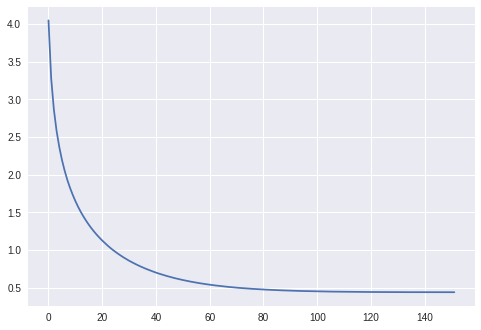

cv= 0.368274 0.381833 ( 153 )


In [869]:
print(history['test-rmsle-mean'].min(),history['test-rmsle-mean'].argmin(),history['train-rmsle-mean'][history['test-rmsle-mean'].argmin()])
plt.plot(history['test-rmsle-mean']); plt.show()
dff = (train_cv-dtrainCV.get_label()); 
_, train_rmsle_CVM = rmsle((train_cv+1.7*dff.mean()),dtrainCV)
print 'cv=',train_rmsle_CV, train_rmsle_CVM, '(', history['test-rmsle-mean'].argmin()+2, ')' #,'train=',train_rmsle, '(', rvalid_log.argmin(), ')'

count    2.623500e+04
mean    -1.023076e+05
std      5.826864e+05
min     -1.097178e+07
25%     -3.728685e+05
50%     -8.779750e+04
75%      1.267260e+05
max      3.396276e+06
dtype: float64
<class 'pandas.core.frame.DataFrame'> (144, 7) Index([u'sub_area', u'fmin', u'fmax', u'fmean', u'fmedian', u'fstd',
       u'fcount'],
      dtype='object') sub_area    144
fmin        144
fmax        144
fmean       144
fmedian     144
fstd        143
fcount      144
dtype: int64 (26235,)
   sub_area       fmin        fmax          fmean    fmedian           fstd  \
0         0 -2171158.0  1652416.25  -80532.492188 -105214.25  538287.062500   
1         1 -5496844.0  2123318.25 -190084.281250 -128298.00  658510.062500   
2         2 -2667654.0  1969834.00 -227522.828125 -135437.50  608757.062500   
3         3 -1396341.0  2757374.50 -102864.546875  -70376.00  652046.625000   
4         4  -303095.5   336026.00  -17680.699219  -39723.00  234262.078125   

   fcount  
0   108.0  
1   161.0  
2    75

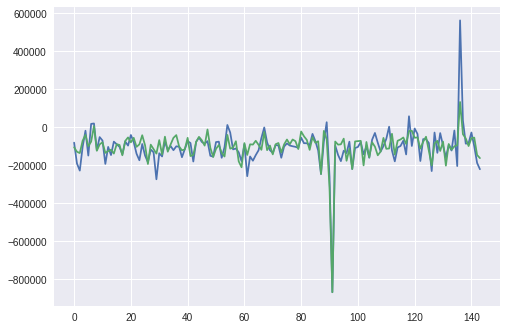

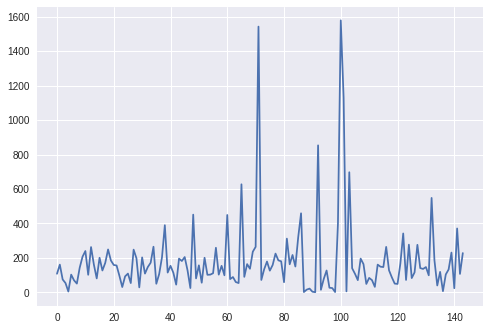

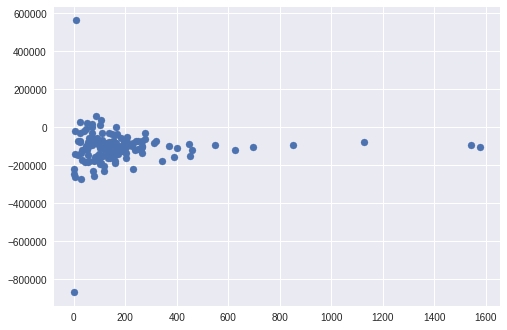

In [271]:
dff     = (train_cv-dtrainCV.get_label())
#grouped = pd.DataFrame(dff).groupby(train_x.year_week,as_index=False)
grouped = pd.DataFrame(dff).groupby(train_x.sub_area,as_index=False)
df = grouped.agg([np.min,np.max,np.mean,np.median,np.std,np.size])
df.columns=['fmin','fmax','fmean','fmedian','fstd','fcount']
df = df.reset_index()
print pd.Series(dff).describe()
print type(df),df.shape,df.columns,df.count(),dff.shape
#print '50',df.year_week[50],'100',df.year_week[100],'125',df.year_week[125],'175',df.year_week[175]
print df.head()
#print df.min(),df.max(),df.mean(),df.std(),df.median()
#plt.plot((train_cv-train_y.r).ravel());
#plt.plot(df.fmin.ravel());
plt.plot(df.fmean.ravel());
plt.plot(df.fmedian.ravel());
#plt.plot(df.fmax.ravel());
plt.show()
plt.plot(df.fcount.ravel());
plt.show()
plt.scatter(df.fcount.ravel(),df.fmean.ravel());
plt.show()

In [45]:
def vFeatures (param,train_x,train_y,col_ver,num_round=100) :
    res = []
    for icol in col_ver :
        try :
            train_x_s = train_x.copy()
            if len(icol)>0 :
                train_x_s = train_x_s.drop(icol,axis=1)
            #print(train_x_s.columns)
            dtrainCV = xgb.DMatrix(train_x_s,label=train_y)
            #history = xgb.cv(param, dtrainCV, verbose_eval=10, metrics='rmse',num_boost_round=num_round,nfold=5,early_stopping_rounds=10)
            history = xgb.cv(param, dtrainCV, verbose_eval=10, feval=rmsle, num_boost_round=num_round,nfold=5,early_stopping_rounds=10)

            watchlistCV  = [(dtrainCV,'train')]
            rvalidCV = {}
            bstCV = xgb.train(param, dtrainCV, history['test-rmsle-mean'].argmin()+2, watchlistCV, feval=rmsle, evals_result=rvalidCV)
            train_cv = bstCV.predict(dtrainCV)
            train_cv = np.abs(train_cv)
            _,train_rmsle_CV = rmsle(train_cv,dtrainCV)
            print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M'),icol,train_rmsle_CV)    
            res.append([icol,train_rmsle_CV])
        except :
            print(icol,'error')
        finally :
            pass
    return(res)
        
param = {'silent':0, 'objective':'reg:linear', 'eta':0.2, 'max_depth':19, 'subsample':0.7, 'colsample_bytree':0.99, 'metrics':'rmse'}
param = {'silent':0, 'objective':'reg:linear', 'eta':0.2, 'max_depth':12, 'subsample':0.7, 'colsample_bytree':0.99, 'metrics':'rmse'}
param = {'silent':0, 'objective':'reg:linear', 'eta':0.2, 'max_depth':5, 'subsample':0.7, 'colsample_bytree':0.7, 'metrics':'rmse'}

list1 = ['day', 'month', 'year', 'week', 'weekday']
list2 = ['build_year0','full0','life0','floor0','max_floor0','floor:max','max-floor','kitch:full','life:full','full:room','life:room','full-life','build-year']
list3 = ['div_usdrub','div_usdrub2','div_eurrub','div_eurrub2','usdrub','eurrub']
list4 = ['full_sq','life_sq','floor','max_floor','build_year']

listAll = train_x.columns.values.tolist()
##listB = listAll[200:]
##listE = listAll[:200]

listX = listAll

resX1 = vFeatures(param,train_x,train_y,['']+listX)
#resB = vFeatures(param,train_x,train_y,['']+listB)
#resE = vFeatures(param,train_x,train_y,['']+listE)

[0]	train-rmsle:1.60093+0.000615785	test-rmsle:1.60148+0.00214585
[10]	train-rmsle:0.274802+0.00173693	test-rmsle:0.280964+0.00641155
[20]	train-rmsle:0.260014+0.00195027	test-rmsle:0.27231+0.00737642
[30]	train-rmsle:0.2535+0.00223535	test-rmsle:0.271551+0.00731653
[40]	train-rmsle:0.247377+0.00232211	test-rmsle:0.270509+0.00737427
[50]	train-rmsle:0.24235+0.0023168	test-rmsle:0.269795+0.00731334
[60]	train-rmsle:0.238011+0.00244226	test-rmsle:0.269696+0.00738089
[70]	train-rmsle:0.234048+0.00234781	test-rmsle:0.269588+0.00728085
[80]	train-rmsle:0.230103+0.00236319	test-rmsle:0.269543+0.00705805
[0]	train-rmsle:1.60331
[1]	train-rmsle:1.02786
[2]	train-rmsle:0.73948
[3]	train-rmsle:0.567399
[4]	train-rmsle:0.457855
[5]	train-rmsle:0.386904
[6]	train-rmsle:0.341356
[7]	train-rmsle:0.312537
[8]	train-rmsle:0.29405
[9]	train-rmsle:0.283093
[10]	train-rmsle:0.276103
[11]	train-rmsle:0.271708
[12]	train-rmsle:0.269194
[13]	train-rmsle:0.267603
[14]	train-rmsle:0.26608
[15]	train-rmsle:0.2

In [37]:
#train_x['index']

In [915]:
resX
resX1
#resX = resX+resX1[1:]
len(resX1), len(resX)
resXsort = [x for x in resX if x[1]>resX[0][1]*0.995 and x[0] not in ['kitch_sq','life:full','life0','kitch_sq','week']]
resXsort = sorted(resXsort,key=lambda x: x[1])
listOut1 = [x[0] for x in resXsort]; 
len(listOut1),listOut1

(411,
 ['ice_rink_km',
  'ekder_female',
  'hospice_morgue_km',
  'cafe_count_5000_price_1000',
  'park_km',
  'cafe_sum_500_max_price_avg',
  'eurrub',
  'green_part_1000',
  'cafe_count_500_price_500',
  'big_market_km',
  'university_km',
  'ecology',
  'zd_vokzaly_avto_km',
  'mosque_count_5000',
  'L62',
  'L12',
  'L123',
  'trc_count_5000',
  'day',
  'office_sqm_500',
  'cafe_count_1500_price_1500',
  'cafe_count_3000_price_500',
  'average_provision_of_build_contract_moscow',
  'average_provision_of_build_contract',
  'L122',
  'L6',
  'cafe_count_2000_na_price',
  'mkad_km',
  'cafe_sum_3000_min_price_avg',
  'ID_railroad_station_avto',
  'L177',
  'state',
  'cafe_count_2000_price_1000',
  'sadovoe_km',
  'oil_chemistry_km',
  'office_count_500',
  'leisure_count_1000',
  'sport_count_3000',
  'radiation_km',
  'ID_metro',
  'L56',
  'L5',
  'trc_count_2000',
  'L58',
  'micex_cbi_tr',
  'deposits_growth',
  'area_m',
  'trc_sqm_2000',
  'load_of_teachers_preschool_per_teach

In [877]:
resXXsort = resX
resXXsort = sorted(resXXsort,key=lambda x: x[1],reverse=True)
##listOut1 = [x[0] for x in resXsort]; 
resXXsort

[['sport_objects_raion', 0.37185946],
 ['cemetery_km', 0.37157923],
 ['green_part_500', 0.37150562],
 ['cafe_count_1500', 0.37117377],
 ['trc_sqm_500', 0.37113219],
 ['big_church_count_1000', 0.37075922],
 ['L116', 0.37060791],
 ['indust_part', 0.37051281],
 ['preschool_education_centers_raion', 0.37046155],
 ['L149', 0.37040308],
 ['leisure_count_3000', 0.37037402],
 ['stadium_km', 0.37027431],
 ['rent_price_2room_eco', 0.37018549],
 ['cafe_count_3000_price_2500', 0.37009165],
 ['big_church_count_5000', 0.37001881],
 ['cafe_sum_5000_max_price_avg', 0.36998978],
 ['thermal_power_plant_raion', 0.36990732],
 ['oil_urals', 0.36990303],
 ['cafe_count_1500_price_2500', 0.36988041],
 ['ekder_male', 0.3698681],
 ['16_29_male', 0.36985916],
 ['trc_count_500', 0.36985049],
 ['ekder_all', 0.36984584],
 ['office_raion', 0.3698273],
 ['num_room', 0.36980423],
 ['0_17_female', 0.36976898],
 ['work_female', 0.36976674],
 ['raion_build_count_with_material_info', 0.3696976],
 ['children_preschool', 0.

In [54]:
resX1
resXX =[1,2,3]
import pickle
ff=open('../Temp/listX1.pcl','w')
pickle.dump(resX1,ff)
ff.close()
##ff=open('../Temp/listX1.pcl','r')
##resYY = pickle.load(ff)
##ff.close()
##resYY

In [205]:
for ii in rr : print ii

[0, 5, 640, 274, 0.49635800000000002, 427.69666, 12081.401]
[5, 10, 945, 425, 0.51961999999999997, 229.52989, 10759.421]
[10, 15, 1191, 170, 0.54957100000000003, 316.75485, 7137.3076]
[15, 20, 1246, 141, 0.57065200000000005, 449.70831, 198995.09]
[20, 25, 849, 151, 0.75849699999999998, 261.53488, 11820.343]
[25, 30, 1087, 198, 0.50190000000000001, 706.79462, 614535.12]
[30, 35, 1154, 184, 0.46602399999999999, 616.81488, 602978.81]
[35, 40, 1208, 221, 0.57780799999999999, 393.56015, 11680.995]
[40, 45, 1014, 141, 0.59879800000000005, 451.50348, 7749.8374]
[45, 50, 1226, 270, 0.55420400000000003, 376.20383, 9930.4365]
[50, 55, 846, 367, 0.54253200000000001, 355.76801, 356213.69]
[55, 60, 1371, 200, 0.49113800000000002, 378.98029, 13598.32]
[60, 65, 1535, 197, 0.48666199999999998, 311.78806, 271376.5]
[65, 70, 1463, 171, 0.27464100000000002, 497.04465, 297258.44]
[70, 75, 2670, 205, 0.23500599999999999, 379.76648, 305796.97]
[75, 80, 1194, 306, 0.47662300000000002, 258.436, 11435.91]
[80,

In [89]:
dict_col_le['sub_area'].inverse_transform(range(65,75)+range(85,105))

array(['Mitino', 'Molzhaninovskoe', "Moskvorech'e-Saburovo", 'Mozhajskoe',
       'Nagatino-Sadovniki', 'Nagatinskij Zaton', 'Nagornoe', 'Nekrasovka',
       'Nizhegorodskoe', 'Novo-Peredelkino', 'Pokrovskoe Streshnevo',
       'Poselenie Desjonovskoe', 'Poselenie Filimonkovskoe',
       'Poselenie Kievskij', 'Poselenie Klenovskoe',
       'Poselenie Kokoshkino', 'Poselenie Krasnopahorskoe',
       'Poselenie Marushkinskoe', 'Poselenie Mihajlovo-Jarcevskoe',
       'Poselenie Moskovskij', 'Poselenie Mosrentgen',
       'Poselenie Novofedorovskoe', 'Poselenie Pervomajskoe',
       'Poselenie Rjazanovskoe', 'Poselenie Rogovskoe',
       'Poselenie Shhapovskoe', 'Poselenie Shherbinka',
       'Poselenie Sosenskoe', 'Poselenie Vnukovskoe',
       'Poselenie Voronovskoe'], 
      dtype='|S30')

In [870]:
# Строим результат

In [871]:
dtest = xgb.DMatrix(test_x)
#test_p = bst.predict(dtest,ntree_limit=rvalid_log.argmin())
test_p = bstCV.predict(dtest)
#test_p = bst.predict(dtest)
test_p = np.abs(test_p)

In [873]:
test_r = pd.DataFrame(ttest[['id']]); 
##test_r['price_doc']=np.expm1(test_p)*(test_x.full_sq+1)*test_x.usdrub # 2017-06-02 LB = 0.54
##test_r['price_doc'] = test_p*(test_x.full_sq+1)*test_x.usdrub; # 2017-06-02 LB = 0.361
##test_r['price_doc'] = test_p*(test_x.full_sq+1); # 2017-06-02 LB = 0.41066
##test_r['price_doc'] = test_p*(test_x.life_sq+1)*test_x.usdrub; # 2017-06-02 LB = 0.39

#test_r['price_doc'] = test_p*test_x.life0*test_x.usdrub; # 2017-06-02 LB = 0.37543
#test_r['price_doc'] = test_p*ttest.full0*ttest.usdrub; # 2017-06-02 LB = 0.37296
test_r['price_doc'] = test_p # 2017-06-02 LB = 0.37296

print test_r.price_doc.min(),test_r.price_doc.max(),train.price_doc.min(),train.price_doc.max() 
test_r.head(8)
#test_r.tail(8)
#test_r.shape

1.93438e+06 4.54945e+07 100000 111111112


,id,price_doc
0,30474,4611224.0
1,30475,7814732.0
2,30476,5768723.5
3,30477,5456656.5
4,30478,5034856.5
5,30479,8946790.0
6,30480,4371033.5
7,30481,4320025.5


In [874]:
ntest[test_r.price_doc<0.0]

,timestamp,id,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000


In [875]:
# Результат в файл

In [876]:
test_r[['id','price_doc']].to_csv('../Result/res-54.csv',index=False)

In [433]:
#history[:20]
xgb.__version__
#bst.__dict__

'0.6'

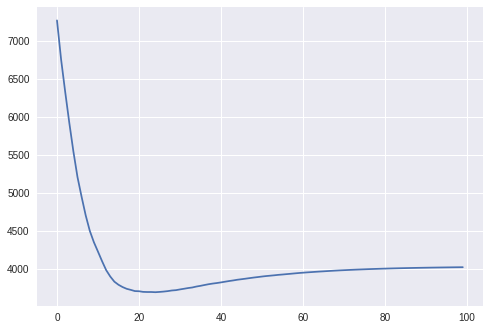

(3691.1898191999999, 24)


In [434]:
plt.plot(history['test-rmse-mean']); plt.show()
print(history['test-rmse-mean'].min(),history['test-rmse-mean'].argmin())

In [803]:
fff = bstCV.get_fscore()
fff = pd.DataFrame(fff.values(),index=fff.keys(),columns=['imp'])
ffs = fff.sort_values('imp')
ffs.tail(60)
#ffs[-150:-60]

,imp
year_week_cnt,157
zd_vokzaly_avto_km,158
theater_km,158
month,159
mosque_km,162
ts_km,166
micex,173
micex_cbi_tr,174
kitch:full,181
ttk_km,185


In [83]:
print train_x.floor0.head(), '\n\n', len(ffs), len(train_x.columns)
ffs['imp'][['material','sub_area','life0','floor','floor0','max_floor0','max-floor','floor:max','max_floor','full0']]

timestamp
2011-08-20    4.0
2011-08-23    3.0
2011-08-27    2.0
2011-09-01    9.0
2011-09-05    4.0
Name: floor0, dtype: float64 

390 474


material       2431.0
sub_area       4460.0
life0          2637.0
floor         18546.0
floor0            NaN
max_floor0        NaN
max-floor      1537.0
floor:max      3558.0
max_floor      5971.0
full0             NaN
Name: imp, dtype: float64

In [103]:
ttrain[ttrain.max_floor0<ttrain.floor0][['floor','max_floor','floor0','max_floor0']].head()
#ttrain[ttrain.max_floor0<1][['floor','max_floor','floor0','max_floor0']].head()
#ttrain[0:10].life_sq.rank()
#pd.Series([0,0,0,0,1,1,1,1,1]).rank()
ttrain[['material']].describe()
pd.concat([pd.DataFrame(train.material.value_counts()/len(train)),pd.DataFrame(test.material.value_counts())/len(test)],axis=1)
ttrain.num_room.value_counts()
#ttrain[ttrain.kitch_sq>ttrain.life0][['kitch_sq','life0','full0']] #.count() #value_counts()
#ttrain[ttrain.num_room<1][['num_room','life0','full0']].head() #.count() #value_counts()
temp=ttrain.sub_area.value_counts()
#train.area_m.value_counts()
pd.DataFrame(temp).reset_index()['index'][:20].values.tolist()

[102.0,
 72.0,
 103.0,
 94.0,
 105.0,
 65.0,
 134.0,
 48.0,
 60.0,
 87.0,
 38.0,
 101.0,
 124.0,
 143.0,
 86.0,
 82.0,
 70.0,
 12.0,
 71.0,
 126.0]

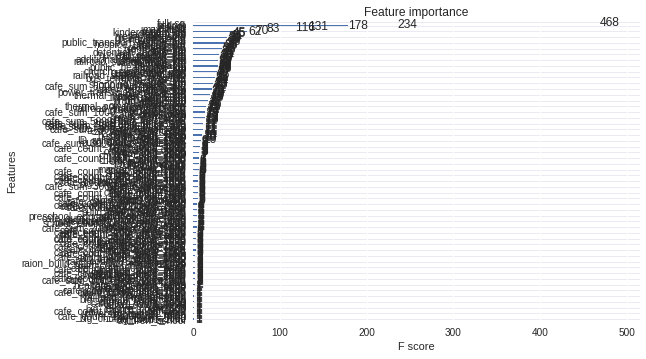

In [61]:
aax = plt.figure(figsize=(16, 16));
xgb.plot_importance(bst); 
#xgb.plot_tree(bst); 
plt.show()

In [8]:
temp=pd.DataFrame(ttrain.columns);

In [9]:
ttrain['sub_area'].unique()

array(['Bibirevo', 'Nagatinskij Zaton', "Tekstil'shhiki", 'Mitino',
       'Basmannoe', 'Nizhegorodskoe', "Sokol'niki", 'Koptevo', 'Kuncevo',
       'Kosino-Uhtomskoe', 'Zapadnoe Degunino', 'Presnenskoe', 'Lefortovo',
       "Mar'ino", "Kuz'minki", 'Nagornoe', "Gol'janovo", 'Vnukovo',
       'Juzhnoe Tushino', 'Severnoe Tushino', "Chertanovo Central'noe",
       'Fili Davydkovo', 'Otradnoe', 'Novo-Peredelkino', 'Bogorodskoe',
       'Jaroslavskoe', 'Strogino', 'Hovrino', "Moskvorech'e-Saburovo",
       'Staroe Krjukovo', 'Ljublino', 'Caricyno', 'Veshnjaki',
       'Danilovskoe', 'Preobrazhenskoe', "Kon'kovo", 'Brateevo',
       'Vostochnoe Izmajlovo', 'Vyhino-Zhulebino', 'Donskoe',
       'Novogireevo', 'Juzhnoe Butovo', 'Sokol', 'Kurkino', 'Izmajlovo',
       'Severnoe Medvedkovo', 'Rostokino', 'Orehovo-Borisovo Severnoe',
       'Ochakovo-Matveevskoe', 'Taganskoe', 'Dmitrovskoe',
       'Orehovo-Borisovo Juzhnoe', 'Teplyj Stan', 'Babushkinskoe',
       'Pokrovskoe Streshnevo', 'Obruc

In [7]:
print(' train=',train.index.min(),train.index.max())
print('ttrain=',ttrain.index.min(),ttrain.index.max())

(' train=', Timestamp('2011-08-20 00:00:00'), Timestamp('2015-06-30 00:00:00'))
('ttrain=', Timestamp('2011-08-20 00:00:00'), Timestamp('2015-06-30 00:00:00'))


In [183]:
acf,confint,qstat,pvalues = sm.tsa.stattools.acf(xtrain,nlags=600,alpha=0.05,qstat=True,fft=True)
#acf
confint.shape #[-10:]
#qstat[-10:]
#pvalues[-10:]
acf[acf>3*confint[:,0]]
#acf.shape, confint.shape
acf[177:185], confint[177:185], qstat[177:185], pvalues[177:185]

(array([ 0.05687618,  0.01495214,  0.01454301,  0.12218533,  0.01729215,
         0.01492026,  0.01349208,  0.01702206]),
 array([[ 0.04518074,  0.06857162],
        [ 0.00322188,  0.02668239],
        [ 0.00281035,  0.02627567],
        [ 0.1104504 ,  0.13392027],
        [ 0.00539791,  0.02918638],
        [ 0.00302285,  0.02681767],
        [ 0.00159232,  0.02539185],
        [ 0.00512036,  0.02892375]]),
 array([ 1404.55727916,  1411.04037485,  1868.68299746,  1877.84943322,
         1884.673916  ,  1890.25462559,  1899.13783036,  1903.71613167]),
 array([  1.93568353e-189,   3.20097876e-190,   2.63858406e-278,
          1.34856387e-279,   1.98803802e-280,   5.14158124e-281,
          2.98600922e-282,   1.21397189e-282]))